In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM

/var/folders/3r/b1hvjmb91q77lp2dj1f9_w980000gn/T/ipykernel_6716/3356426969.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
# Data Preprocessing 
def preprocess_data(df):
    # Drop unwanted columns
    df.drop(['id', 'proto', 'service', 'state'], axis=1, inplace=True)

    # Handle missing values if any
    df.dropna(inplace=True)
    
    # Encode categorical variables
    cat_cols = ['attack_cat','label']
    encoder = LabelEncoder()
    for col in cat_cols:
        df[col] = encoder.fit_transform(df[col])
        
    # Standardize numerical variables
    num_cols = df.select_dtypes(include='number').columns.tolist()
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

# Function for Plotting Histograms
def plot_histograms(df, num_cols):
    df[num_cols].hist(figsize=(50, 45))
    plt.show()

# Function for Plotting Heatmap
def plot_heatmap(df):
    corr = df.corr()
    plt.figure(figsize=(18, 18))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.show()

# Function for Plotting Box Plots
def plot_boxplots(df, num_cols, target_col):
    for col in num_cols:
        sns.boxplot(x=target_col, y=col, data=df)
        plt.show()
        print('\n')
    
# Function for Model Training and Evaluation
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    # Define empty dictionaries to store evaluation metrics
    fpr_tpr_dict = {}
    roc_auc_scores = {}
    p_r_dict = {}
    pr_auc_scores = {}
    accuracy_scores = {}
        
    for model_name, model in models.items():
        # Check if the model is a Keras model
        if isinstance(model, Sequential):
            # Compile the Keras model
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
        # Train the model
        model.fit(X_train, y_train)

        # Predict probabilities on the test set
        if isinstance(model, Sequential):
            y_pred_probs = model.predict(X_test)
            y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions
        else:
            y_pred = model.predict(X_test)

        # Compute Evaluation metrics - accuracy, confusion matrix, classification report, ROC curve, precision-recall curve
        accuracy_scores[model_name] = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        fpr_tpr_dict[model_name] = (fpr, tpr)
        roc_auc_scores[model_name] = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        p_r_dict[model_name] = (precision, recall)
        pr_auc_scores[model_name] = auc(recall, precision)
        
        print(f'{model_name} Accuracy:', accuracy_scores[model_name])
        print(f'{model_name} Confusion Matrix:\n', conf_matrix)
        print(f'{model_name} Classification Report:\n', classification_rep)

        # Plot ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_scores[model_name])
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
        
        # Plot Precision-Recall Curve
        plt.figure()
        plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc_scores[model_name])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend(loc="lower left")
        plt.show()
    return roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict

def plot_evaluation_curves(roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict, model_type):
    # Plotting ROC Curves
    plt.figure(figsize=(10, 5))
    for model_name, (fpr, tpr) in fpr_tpr_dict.items():
        roc_auc = roc_auc_scores[model_name]
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves of {model_type} - Testing Data')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plotting Precision-Recall Curves
    plt.figure(figsize=(10, 5))
    for model_name, (precision, recall) in p_r_dict.items():
        pr_auc = pr_auc_scores[model_name]
        plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves of {model_type} - Testing Data')
    plt.legend(loc="lower left")
    plt.show()

    # Print Accuracy Scores
    for model_name, accuracy in accuracy_scores.items():
        print(f'{model_name} Accuracy:', accuracy)
    
    # Plotting Accuracy Scores
    plt.figure(figsize=(10, 5))
    for model_name, accuracy in accuracy_scores.items():
        plt.plot([model_name], [accuracy], marker='o', label=f'{model_name} (Accuracy = {accuracy:.2f})')
    plt.ylim(0, 1.1)
    plt.title(f'Accuracy Scores of {model_type} - Testing Data')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [7]:
# Read Data
df = pd.read_csv('/Users/sanjithapathuri/Library/Mobile Documents/com~apple~CloudDocs/files/MS/CourseWork/CS584 ML/Project/UNSW_NB15_testing-set.csv')
df = preprocess_data(df)

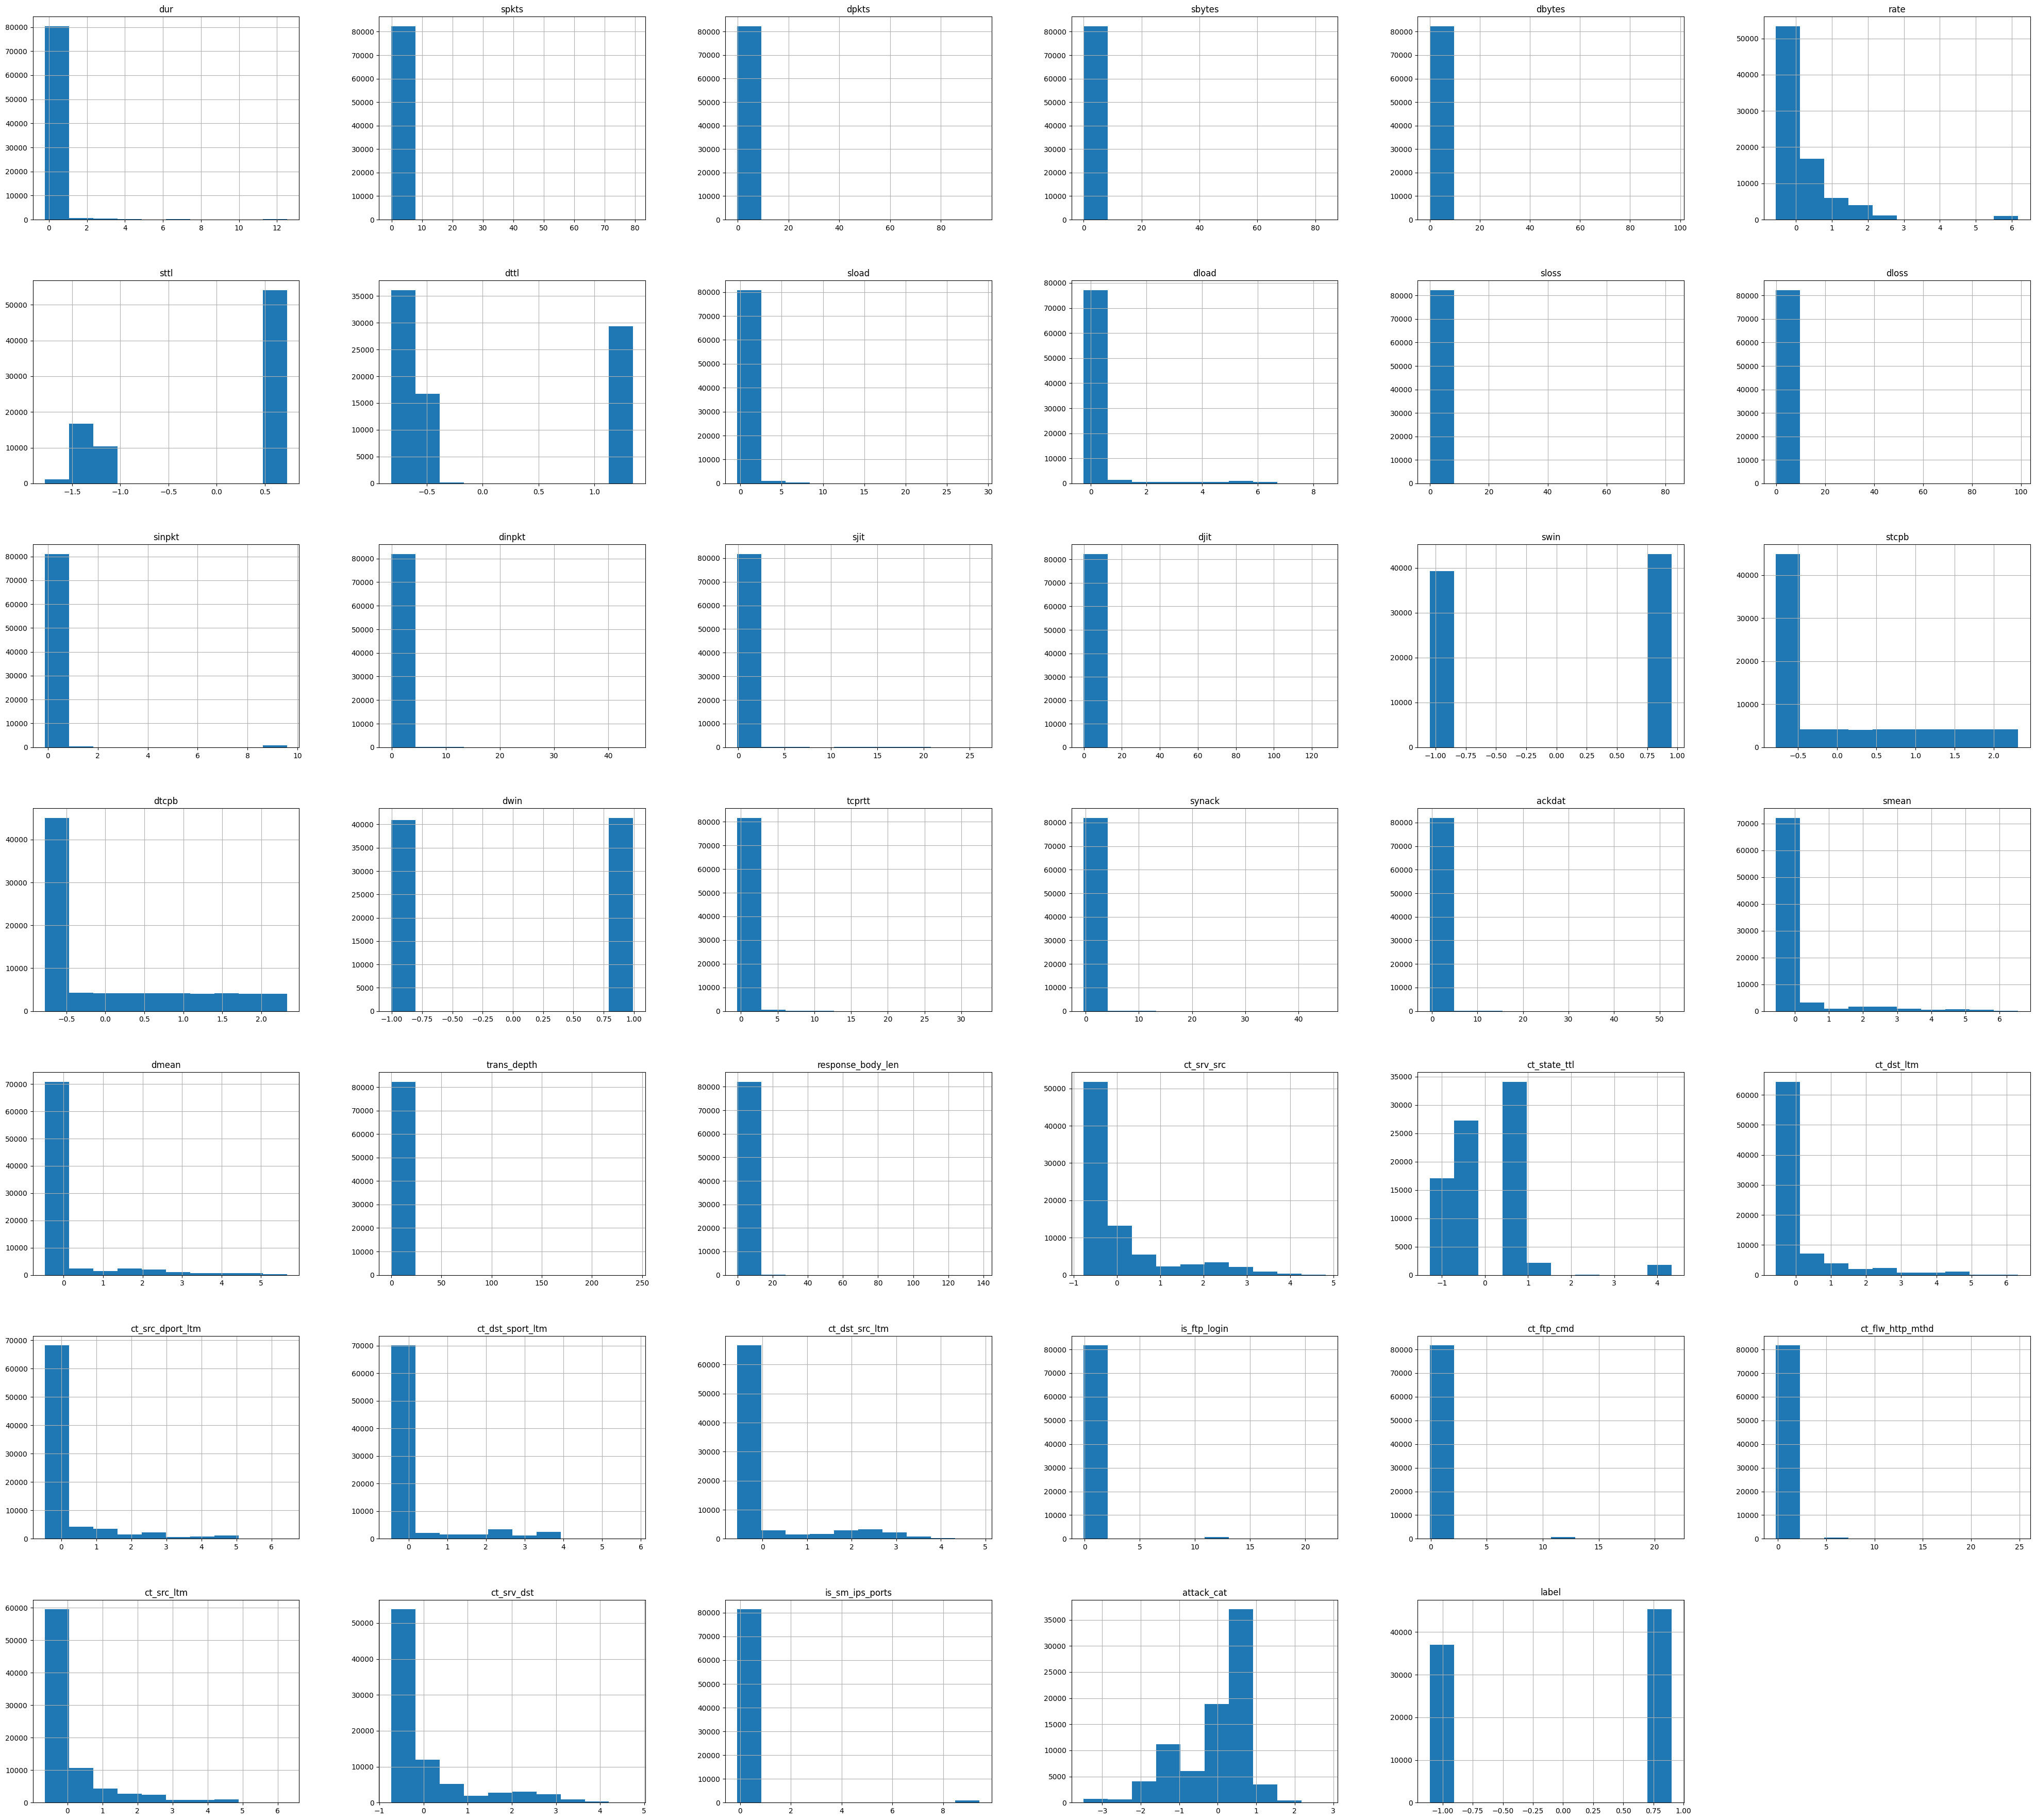

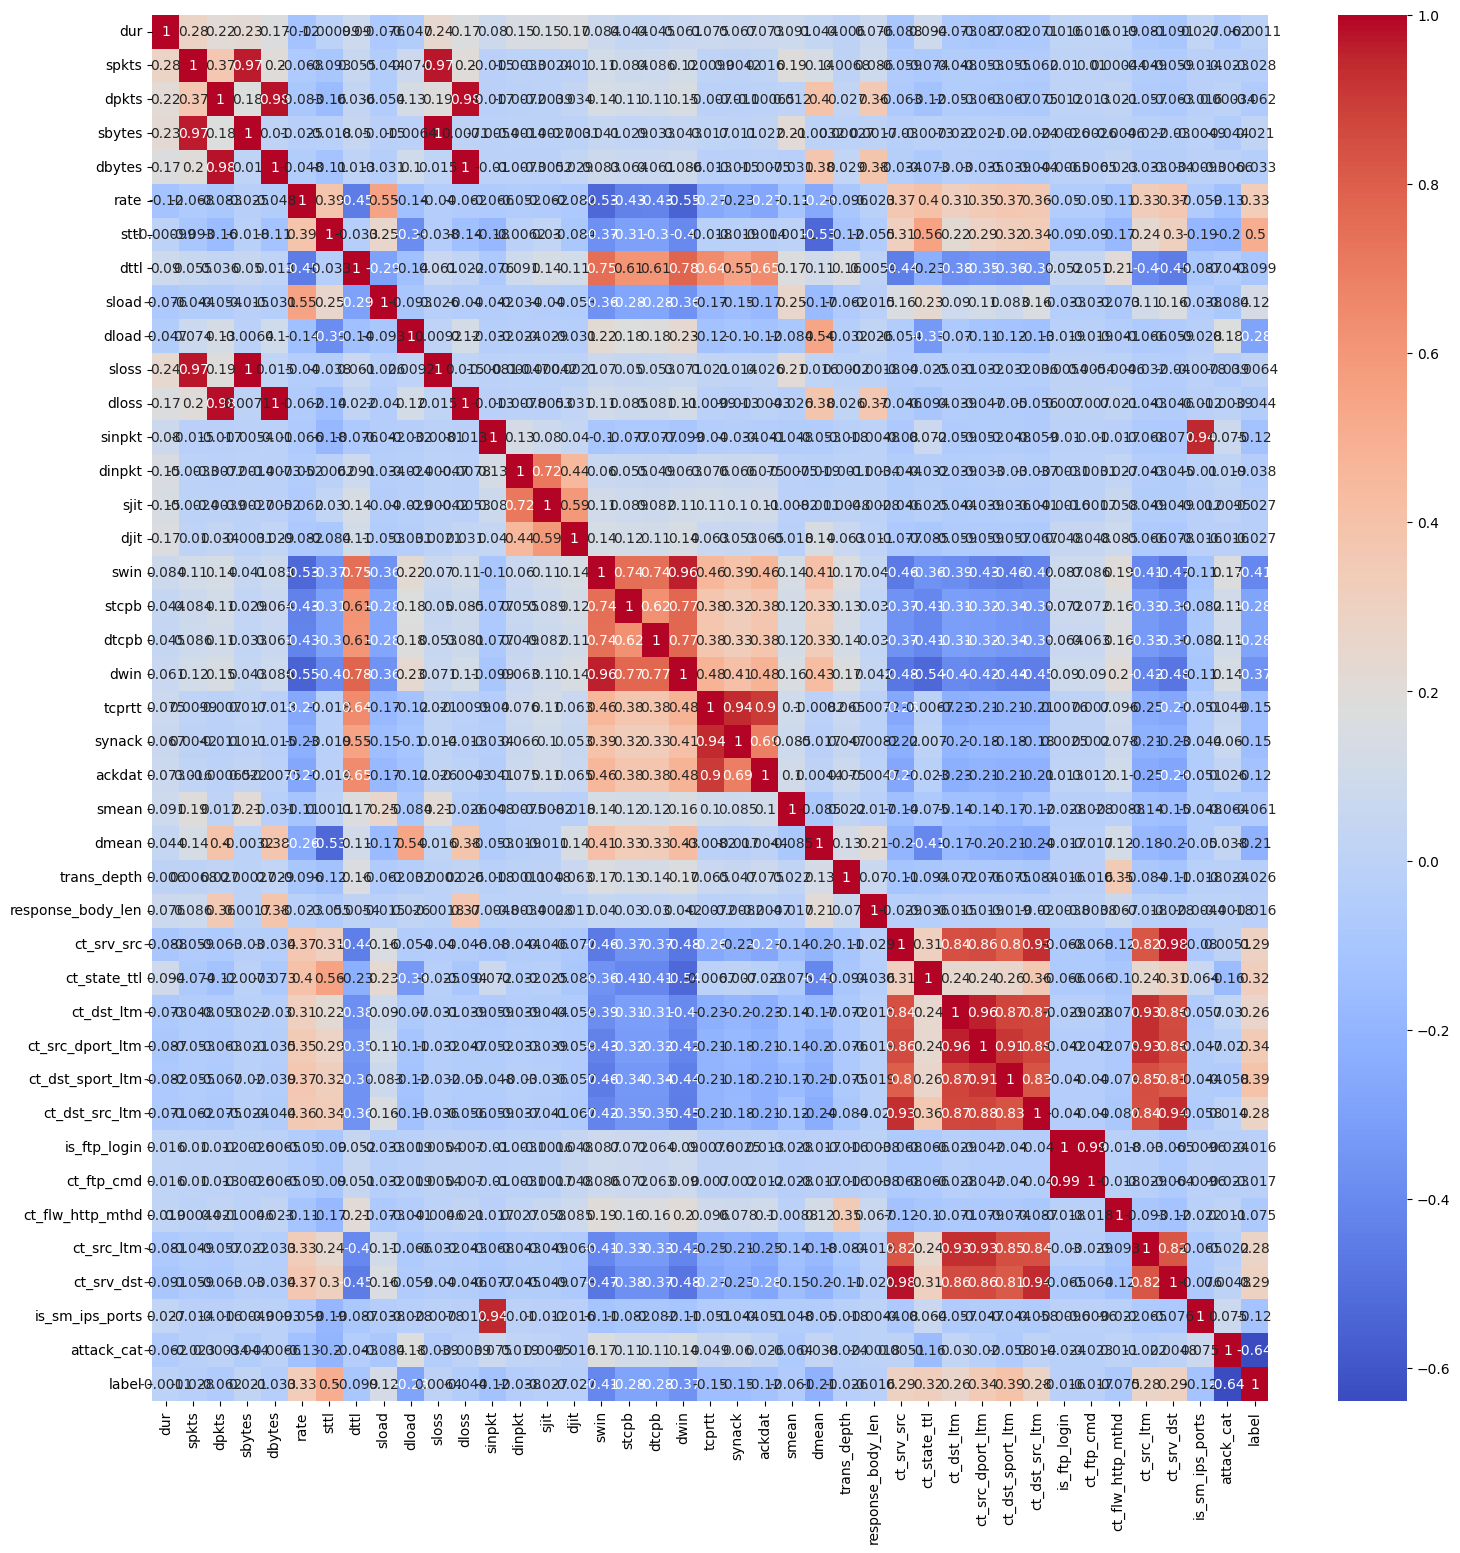

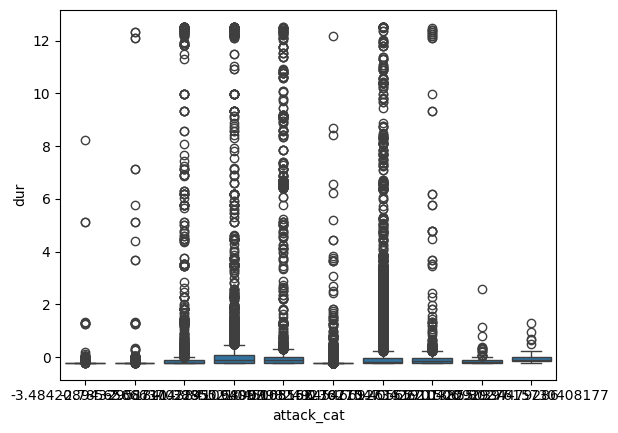

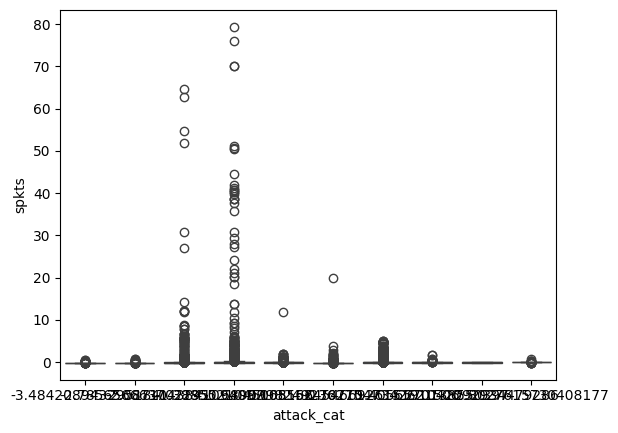

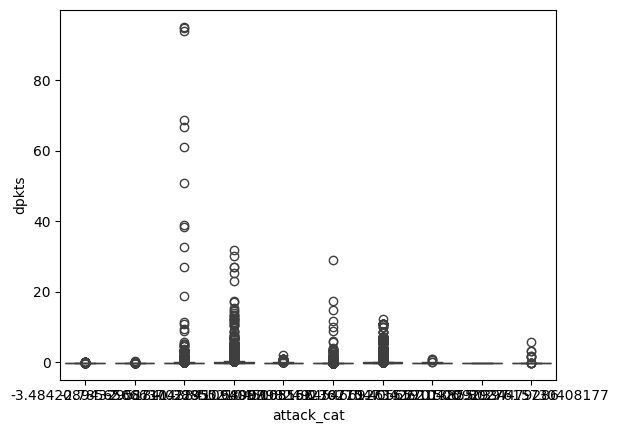

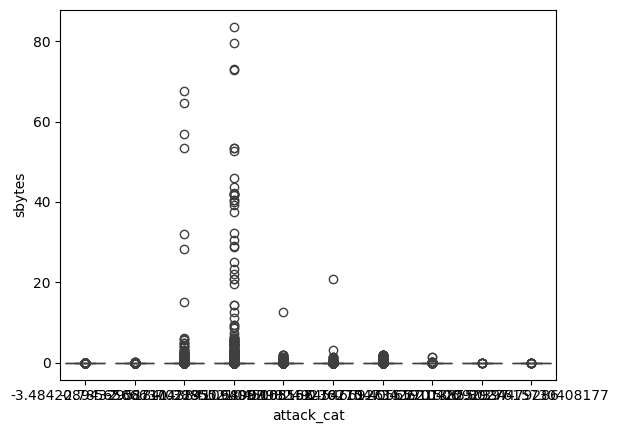

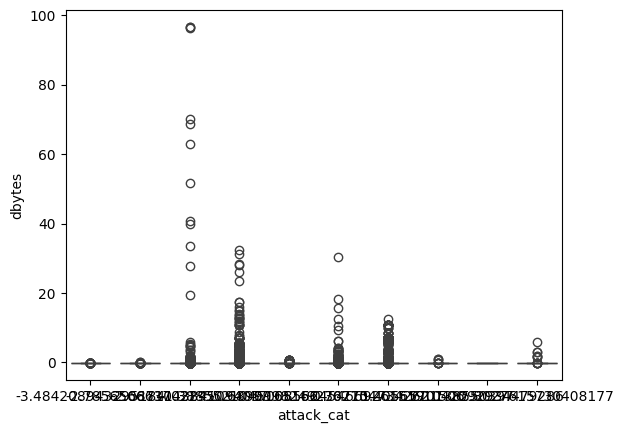

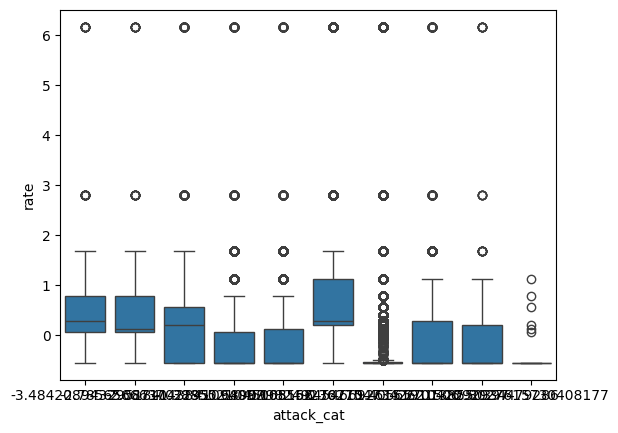

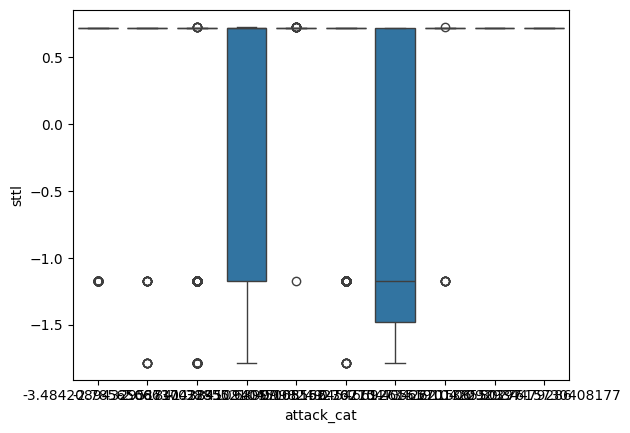

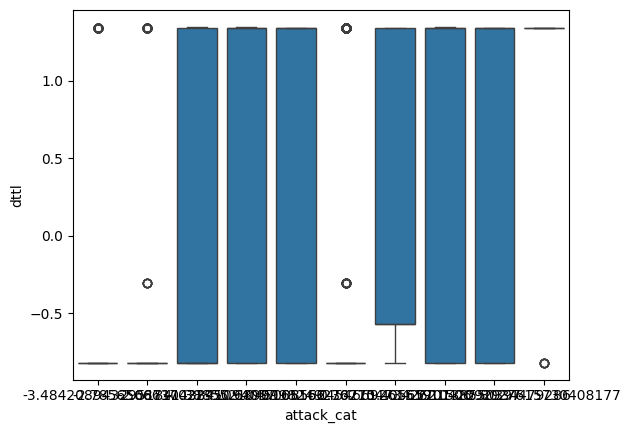

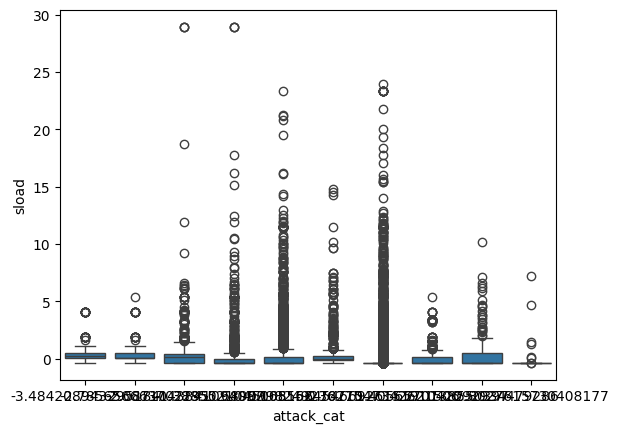

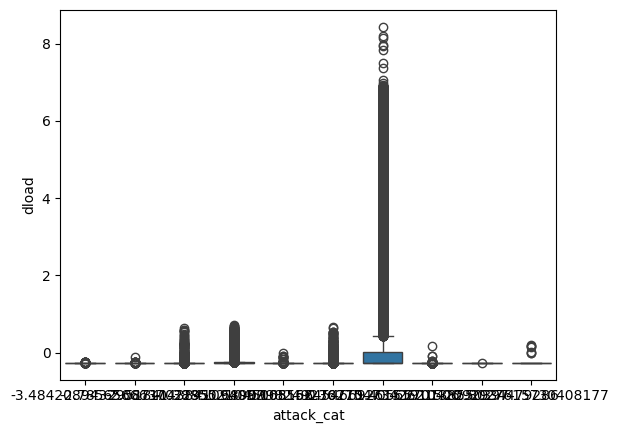

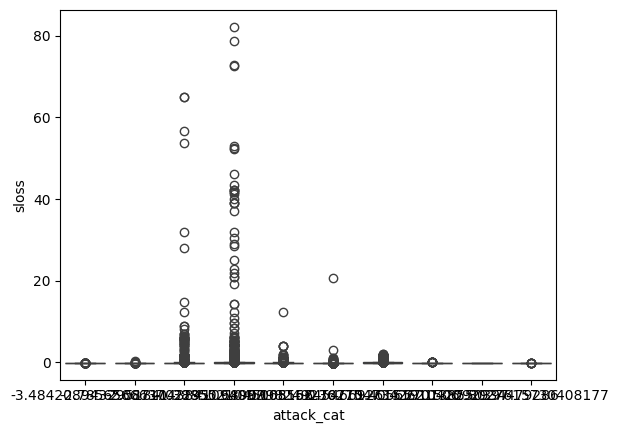

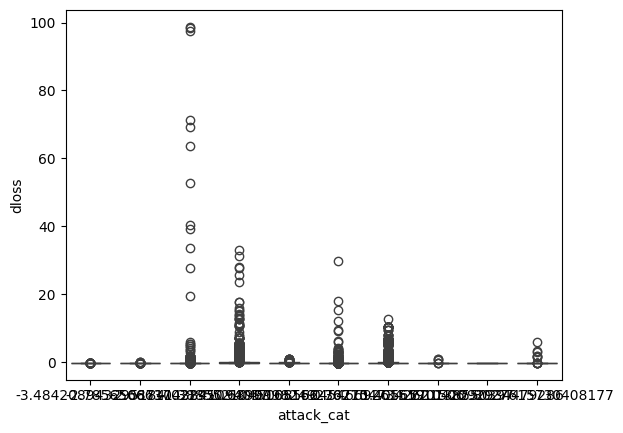

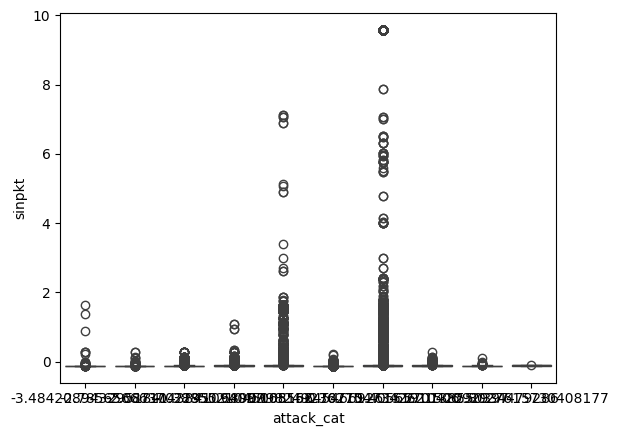

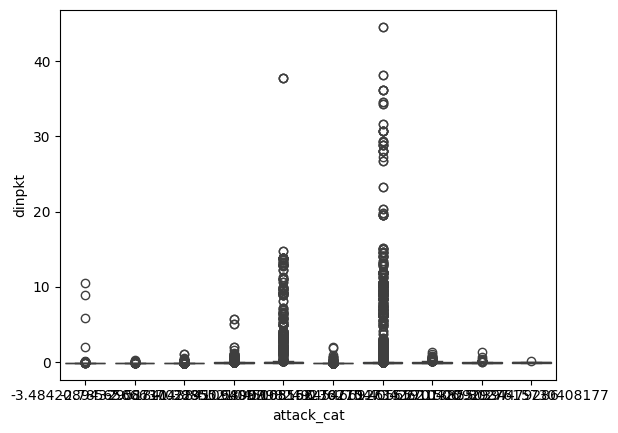

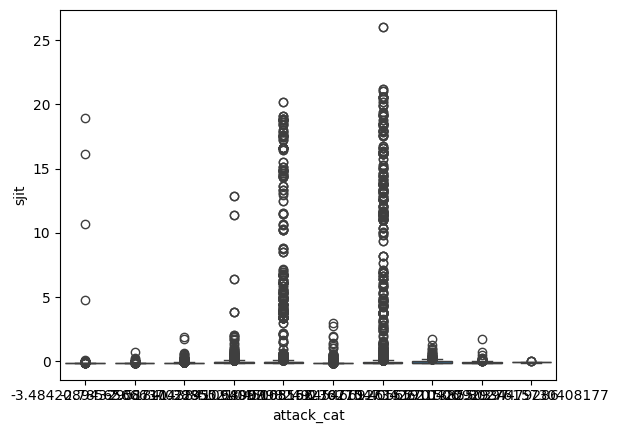

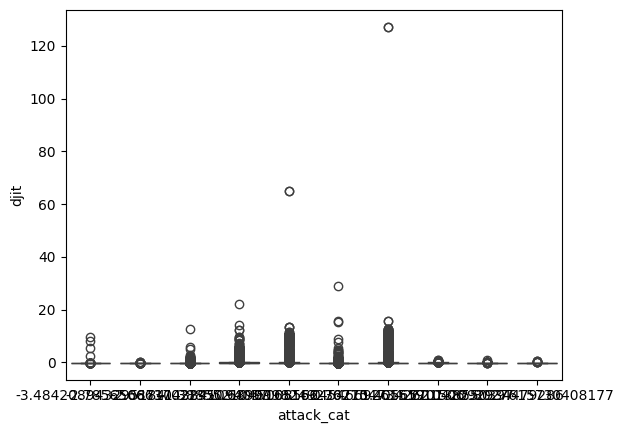

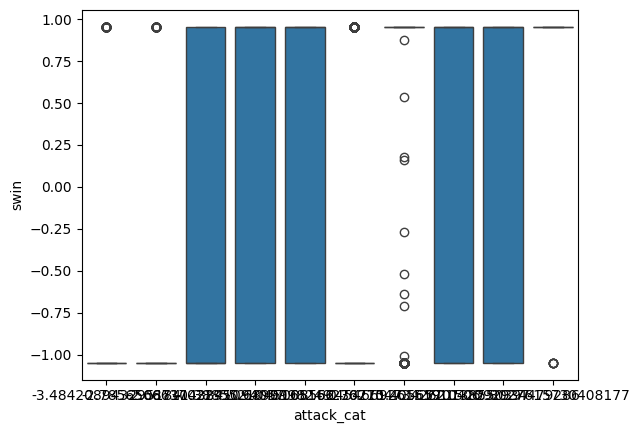

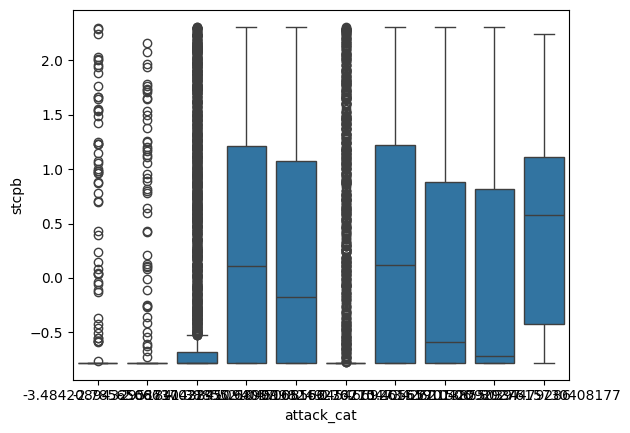

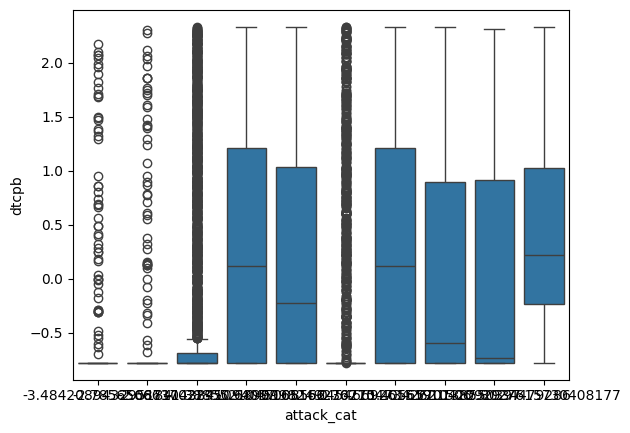

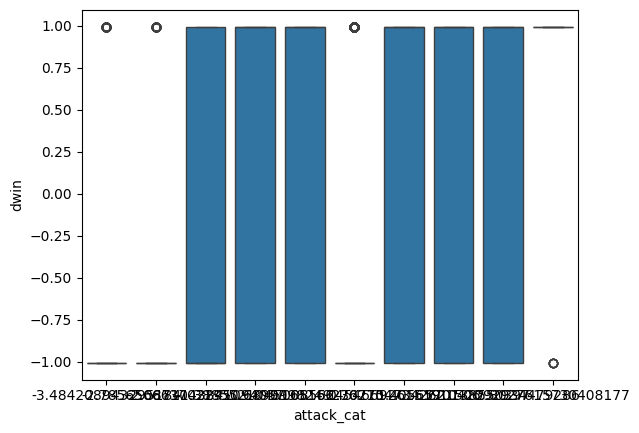

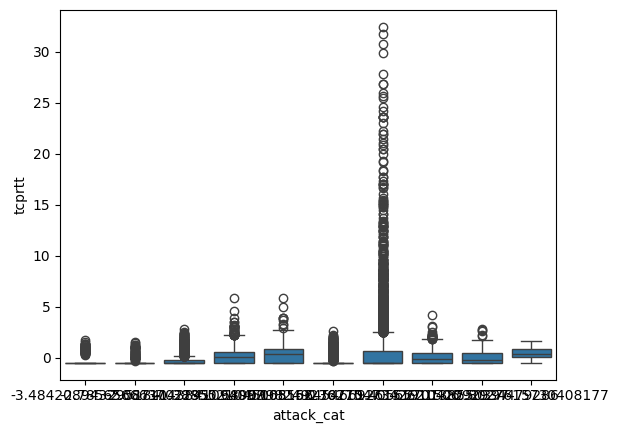

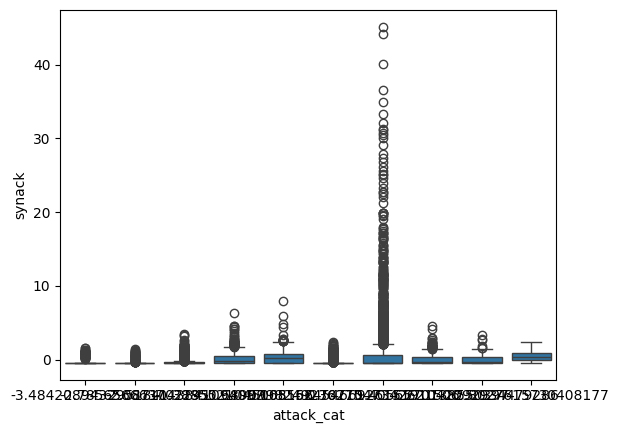

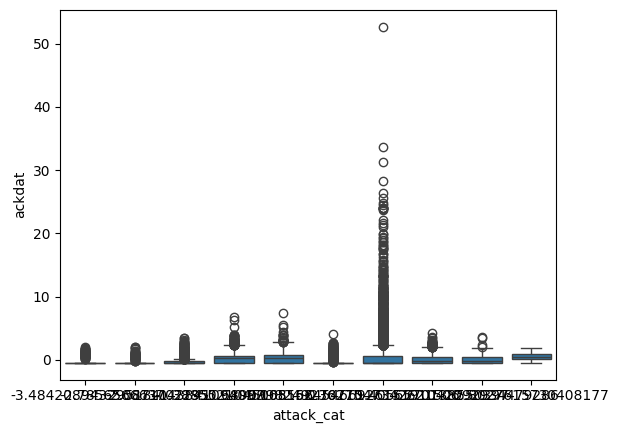

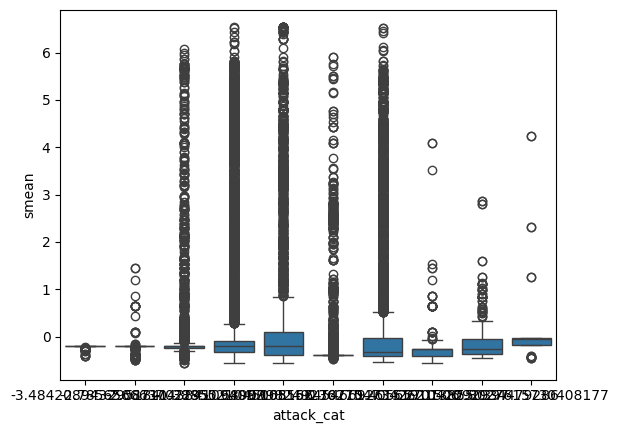

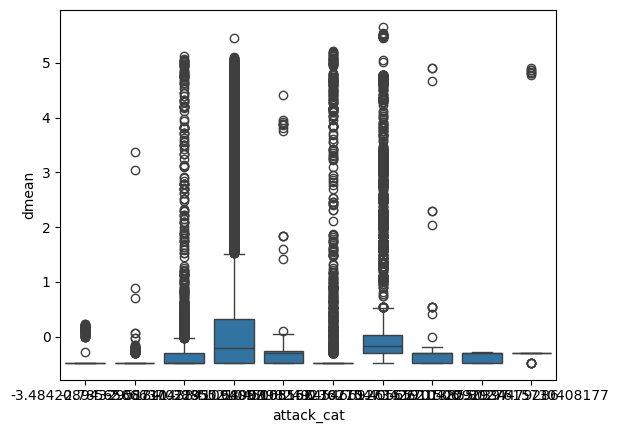

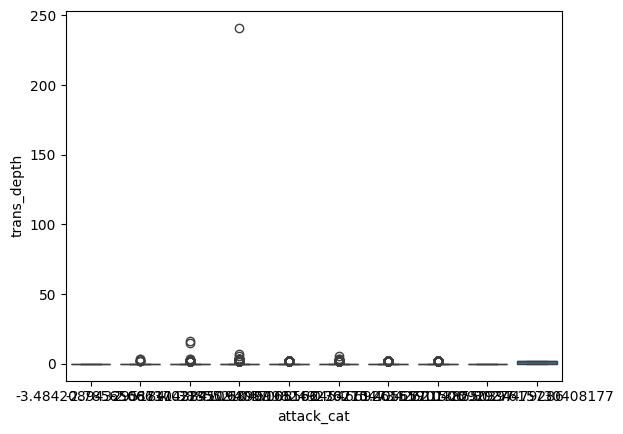

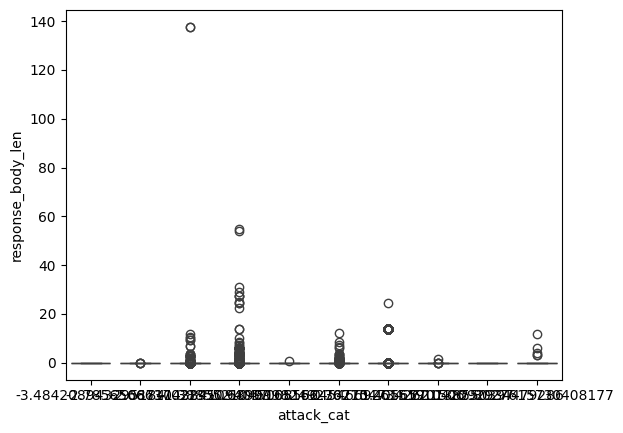

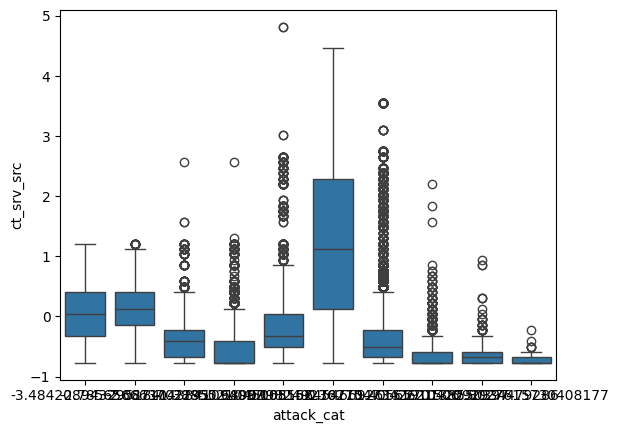

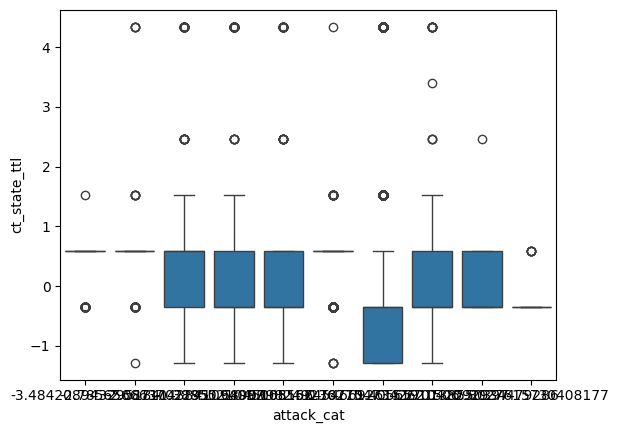

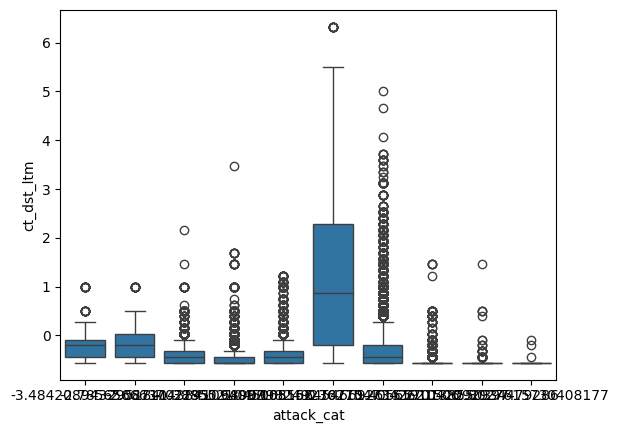

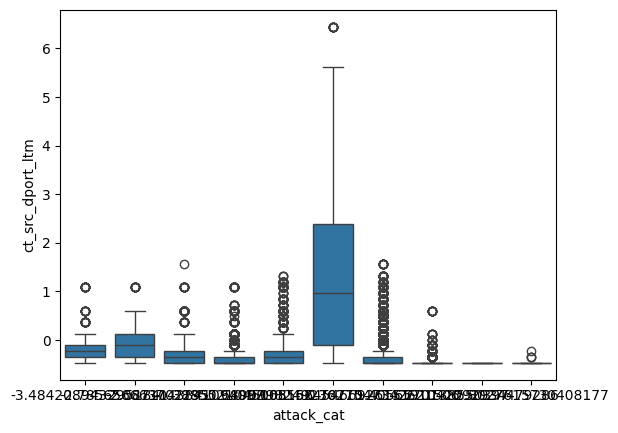

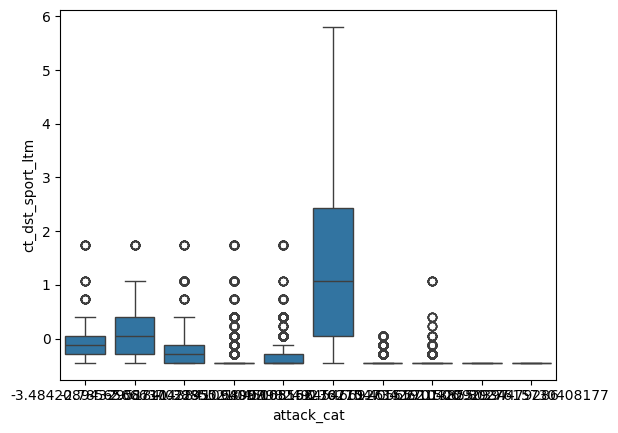

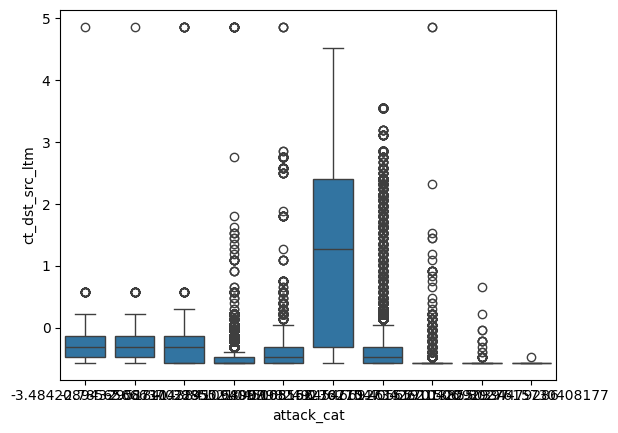

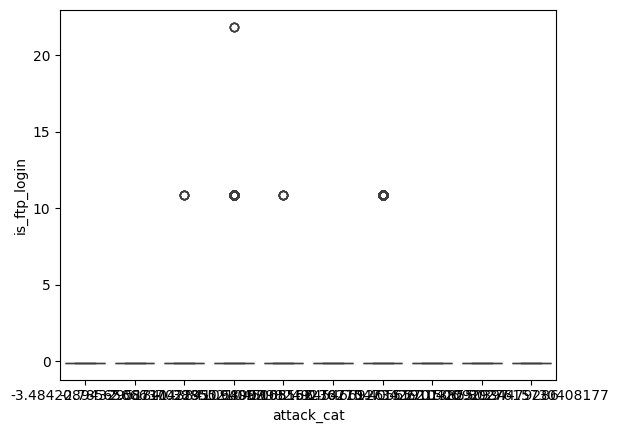

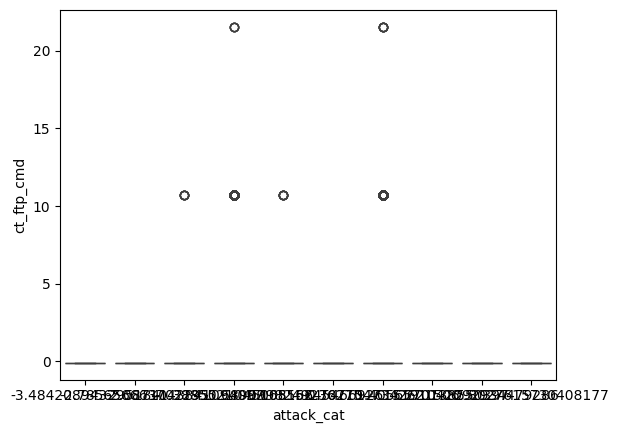

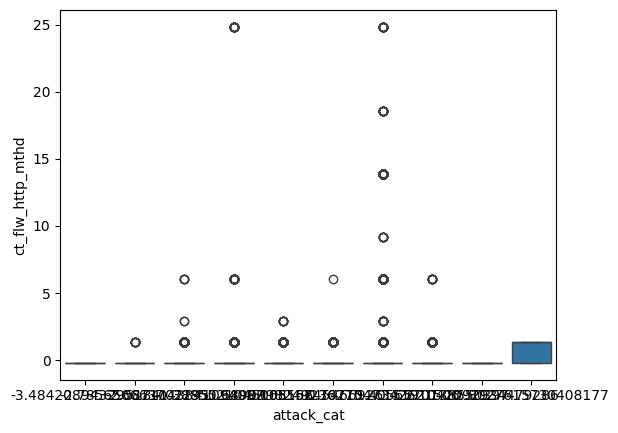

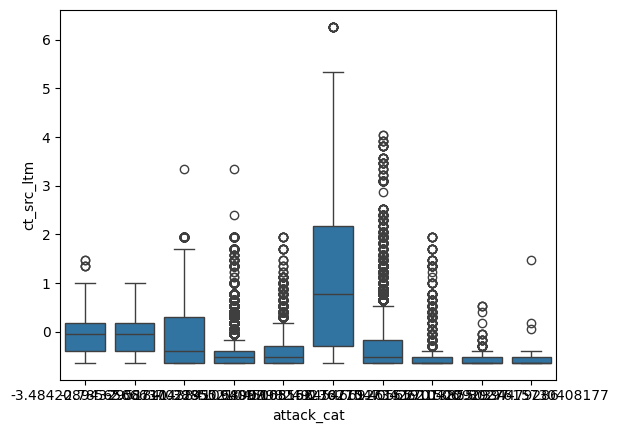

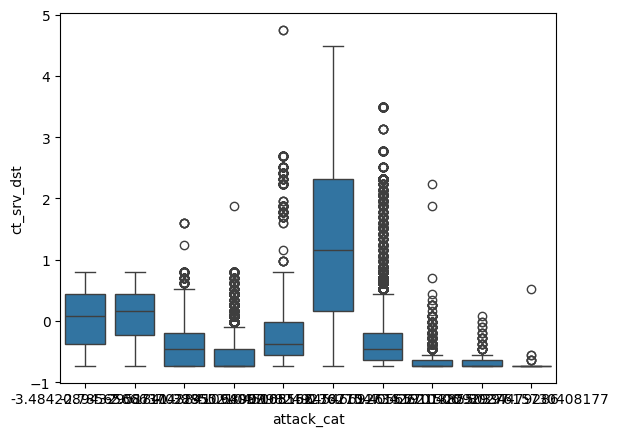

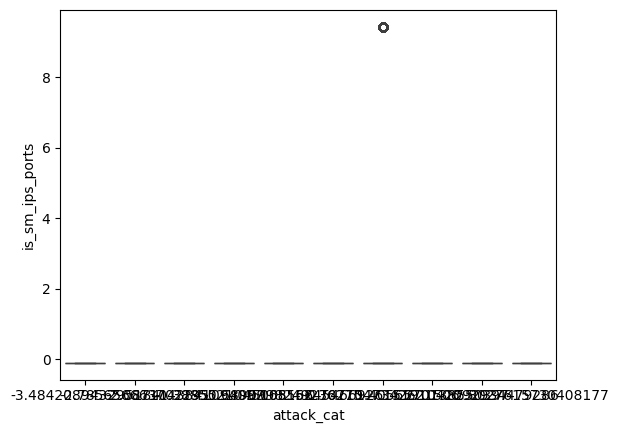

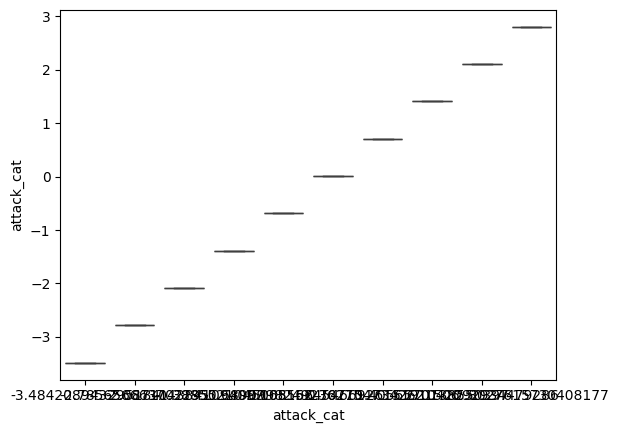

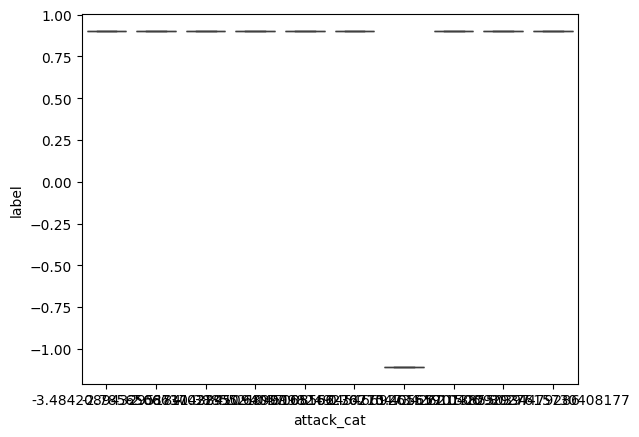

In [8]:
#Exploratory Data Analysis
num_cols = df.select_dtypes(include='number').columns.tolist()
plot_histograms(df, num_cols)
plot_heatmap(df)
plot_boxplots(df, num_cols, 'attack_cat')

In [9]:
X = df.drop(['label'], axis=1)
encoder = LabelEncoder() # Encode the target variable if it represents classes
y = encoder.fit_transform(df['label'])

# Feature Selection
selector = SelectKBest(mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support(indices=True)]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

Logistic Regression Accuracy: 0.9312145748987855
Logistic Regression Confusion Matrix:
 [[10719   428]
 [ 1271 12282]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.93     11147
           1       0.97      0.91      0.94     13553

    accuracy                           0.93     24700
   macro avg       0.93      0.93      0.93     24700
weighted avg       0.93      0.93      0.93     24700



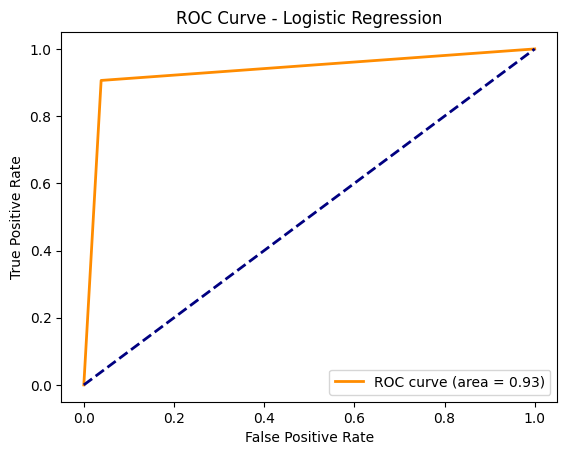

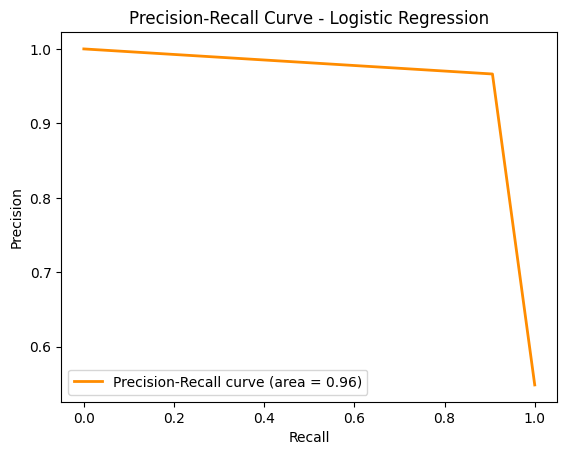

Decision Tree Accuracy: 1.0
Decision Tree Confusion Matrix:
 [[11147     0]
 [    0 13553]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11147
           1       1.00      1.00      1.00     13553

    accuracy                           1.00     24700
   macro avg       1.00      1.00      1.00     24700
weighted avg       1.00      1.00      1.00     24700



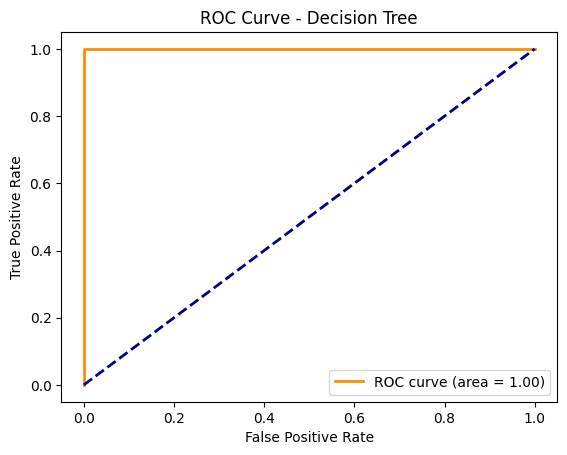

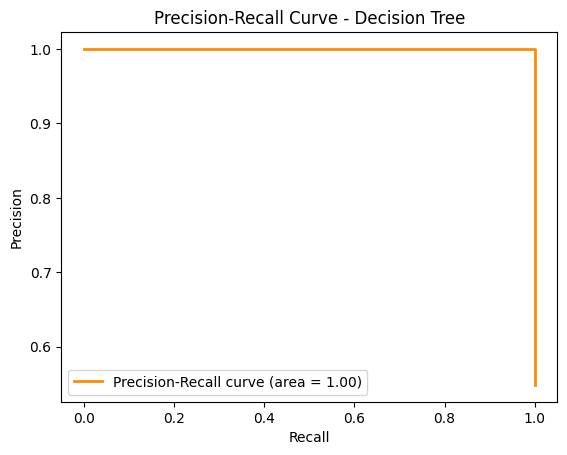

Random Forest Accuracy: 1.0
Random Forest Confusion Matrix:
 [[11147     0]
 [    0 13553]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11147
           1       1.00      1.00      1.00     13553

    accuracy                           1.00     24700
   macro avg       1.00      1.00      1.00     24700
weighted avg       1.00      1.00      1.00     24700



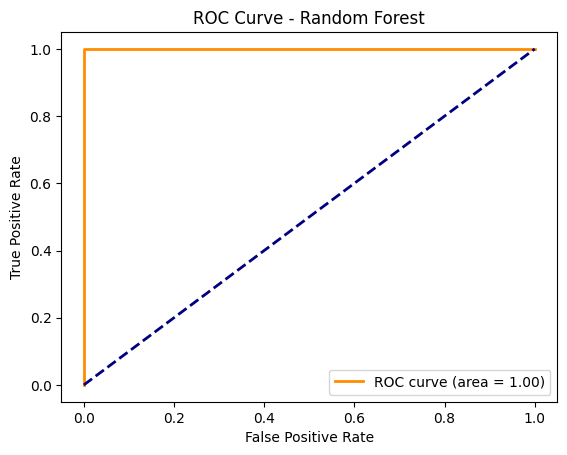

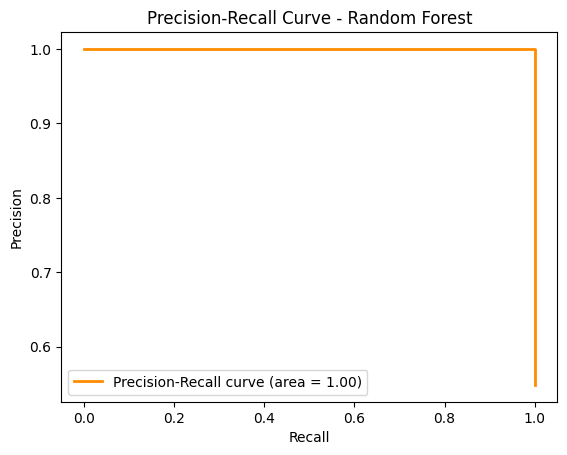

SVM Accuracy: 0.9990283400809716
SVM Confusion Matrix:
 [[11141     6]
 [   18 13535]]
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11147
           1       1.00      1.00      1.00     13553

    accuracy                           1.00     24700
   macro avg       1.00      1.00      1.00     24700
weighted avg       1.00      1.00      1.00     24700



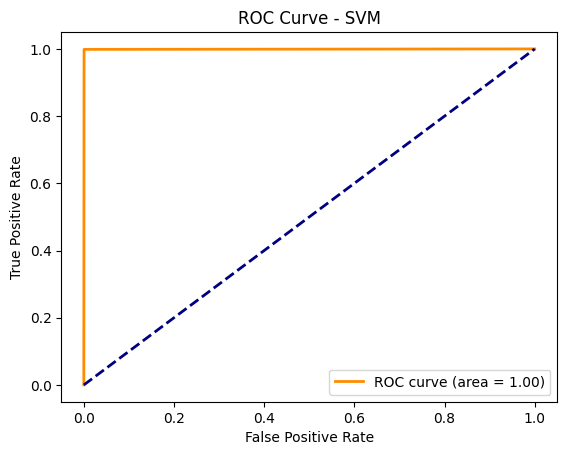

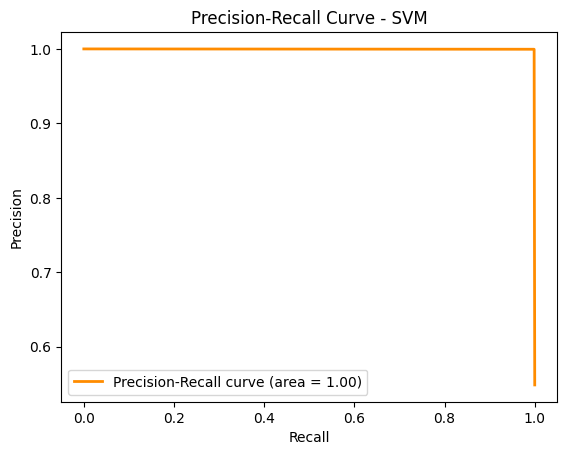

XGBoost Accuracy: 1.0
XGBoost Confusion Matrix:
 [[11147     0]
 [    0 13553]]
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11147
           1       1.00      1.00      1.00     13553

    accuracy                           1.00     24700
   macro avg       1.00      1.00      1.00     24700
weighted avg       1.00      1.00      1.00     24700



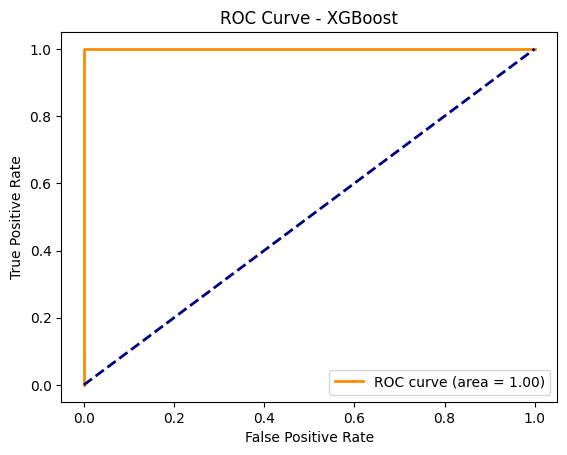

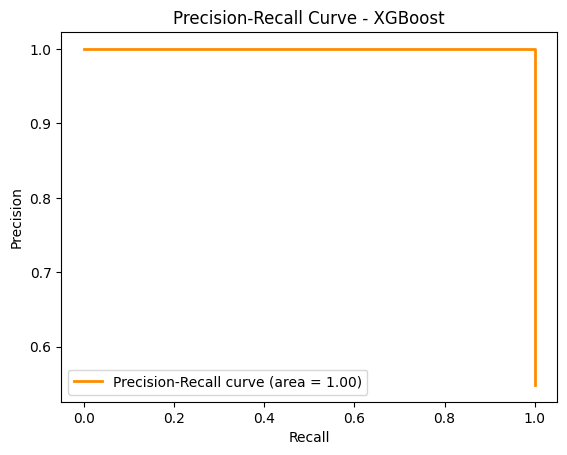

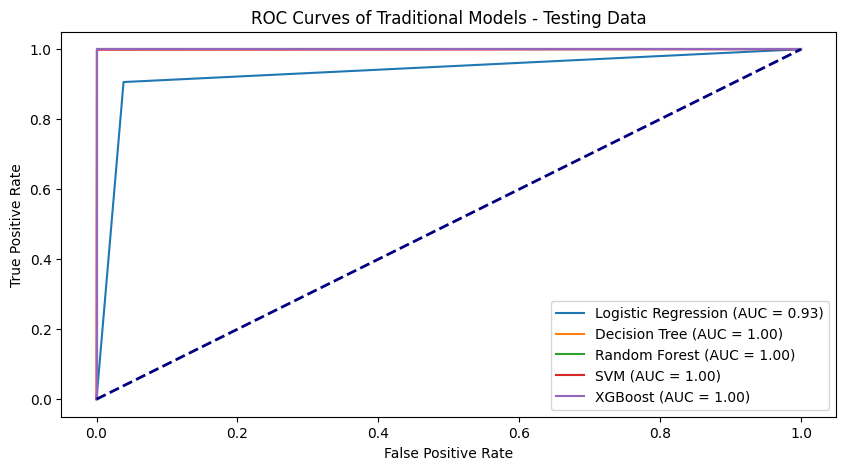

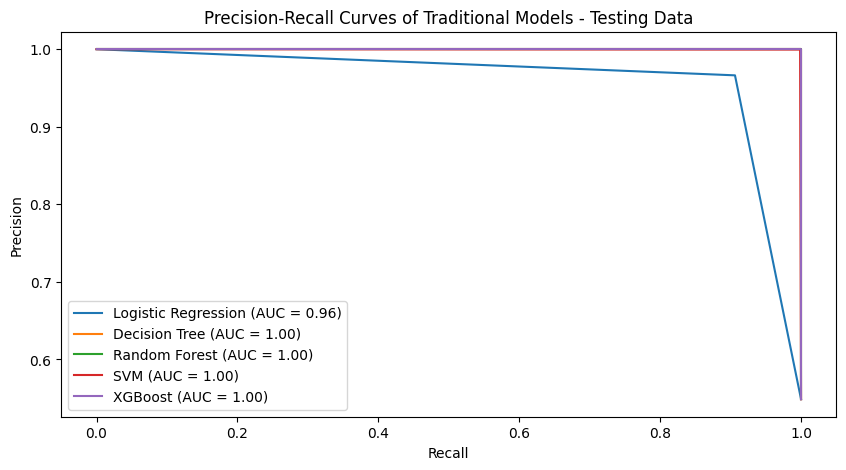

Logistic Regression Accuracy: 0.9312145748987855
Decision Tree Accuracy: 1.0
Random Forest Accuracy: 1.0
SVM Accuracy: 0.9990283400809716
XGBoost Accuracy: 1.0


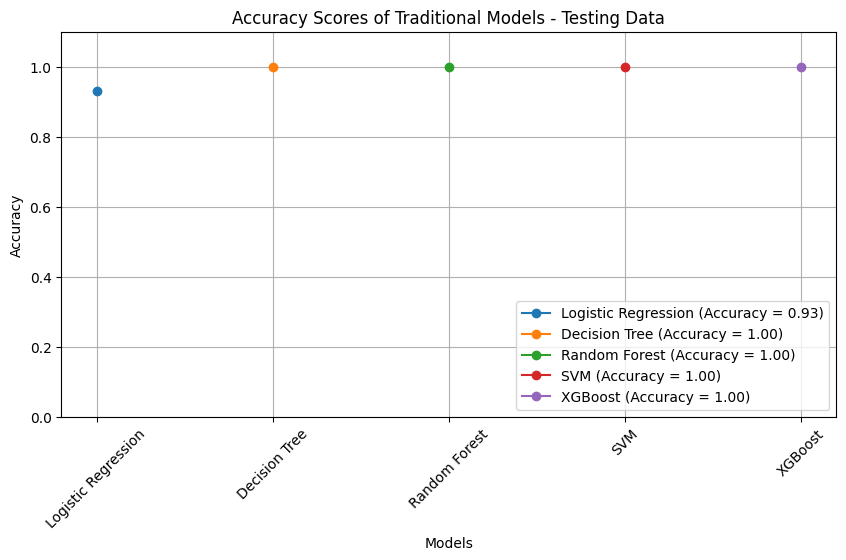

In [10]:
# Traditional Supervised Learning models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier()
}

# Train and evaluate the models 
roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict = train_and_evaluate_models(models, X_train, X_test, y_train, y_test)
    
plot_evaluation_curves(roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict, 'Traditional Models')

/Users/sanjithapathuri/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


MLP Classifier Accuracy: 0.9999595141700405
MLP Classifier Confusion Matrix:
 [[11147     0]
 [    1 13552]]
MLP Classifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11147
           1       1.00      1.00      1.00     13553

    accuracy                           1.00     24700
   macro avg       1.00      1.00      1.00     24700
weighted avg       1.00      1.00      1.00     24700



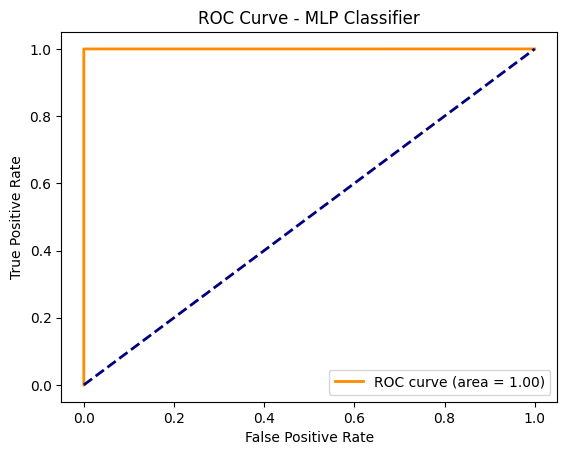

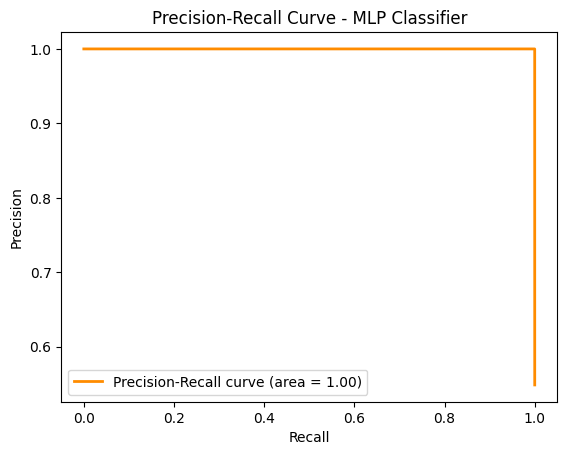

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - accuracy: 0.9301 - loss: 0.2146
772/772 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
Convolutional Neural Network (CNN) Accuracy: 0.9974089068825911
Convolutional Neural Network (CNN) Confusion Matrix:
 [[11142     5]
 [   59 13494]]
Convolutional Neural Network (CNN) Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     11147
           1       1.00      1.00      1.00     13553

    accuracy                           1.00     24700
   macro avg       1.00      1.00      1.00     24700
weighted avg       1.00      1.00      1.00     24700



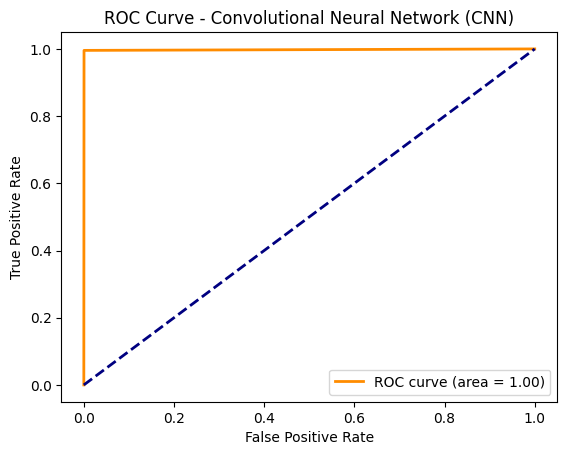

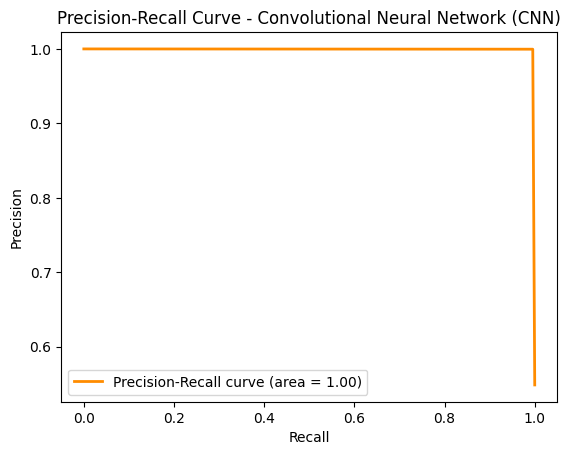

1801/1801 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8957 - loss: 0.2495
772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step
Recurrent Convolutional Neural Network (RCNN) Accuracy: 0.9974089068825911
Recurrent Convolutional Neural Network (RCNN) Confusion Matrix:
 [[11141     6]
 [   58 13495]]
Recurrent Convolutional Neural Network (RCNN) Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     11147
           1       1.00      1.00      1.00     13553

    accuracy                           1.00     24700
   macro avg       1.00      1.00      1.00     24700
weighted avg       1.00      1.00      1.00     24700



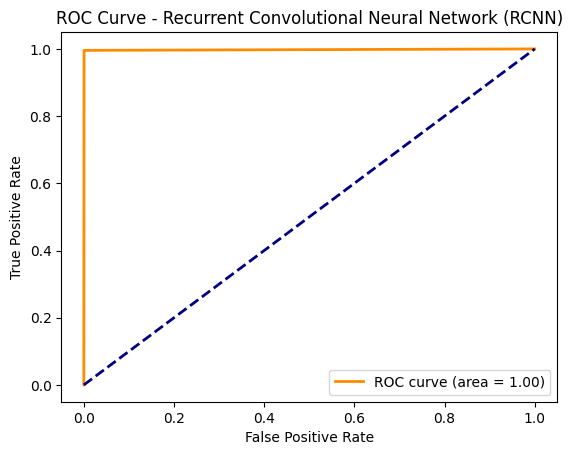

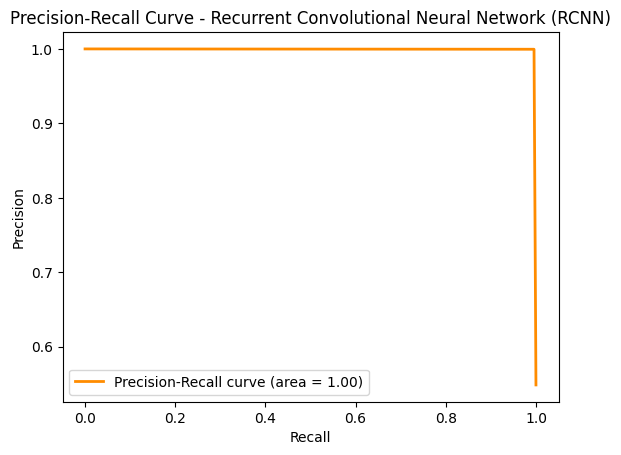

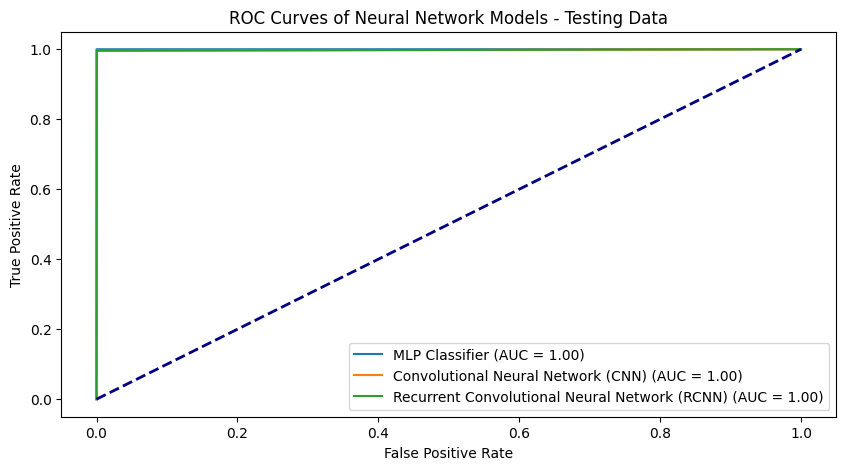

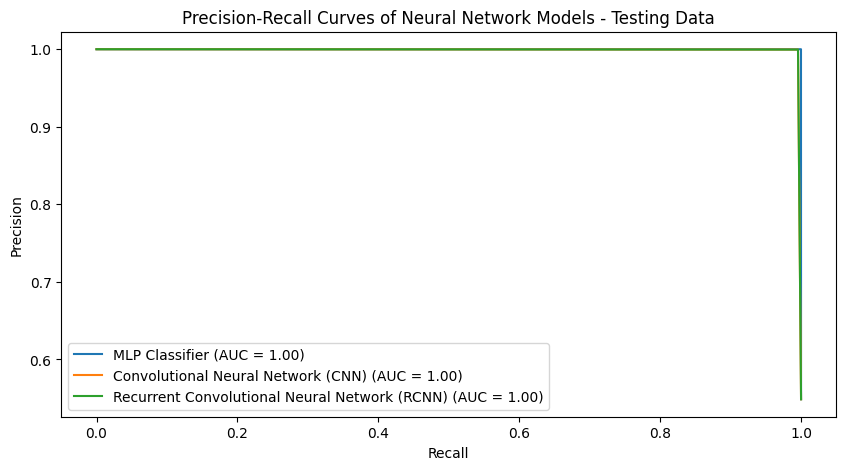

MLP Classifier Accuracy: 0.9999595141700405
Convolutional Neural Network (CNN) Accuracy: 0.9974089068825911
Recurrent Convolutional Neural Network (RCNN) Accuracy: 0.9974089068825911


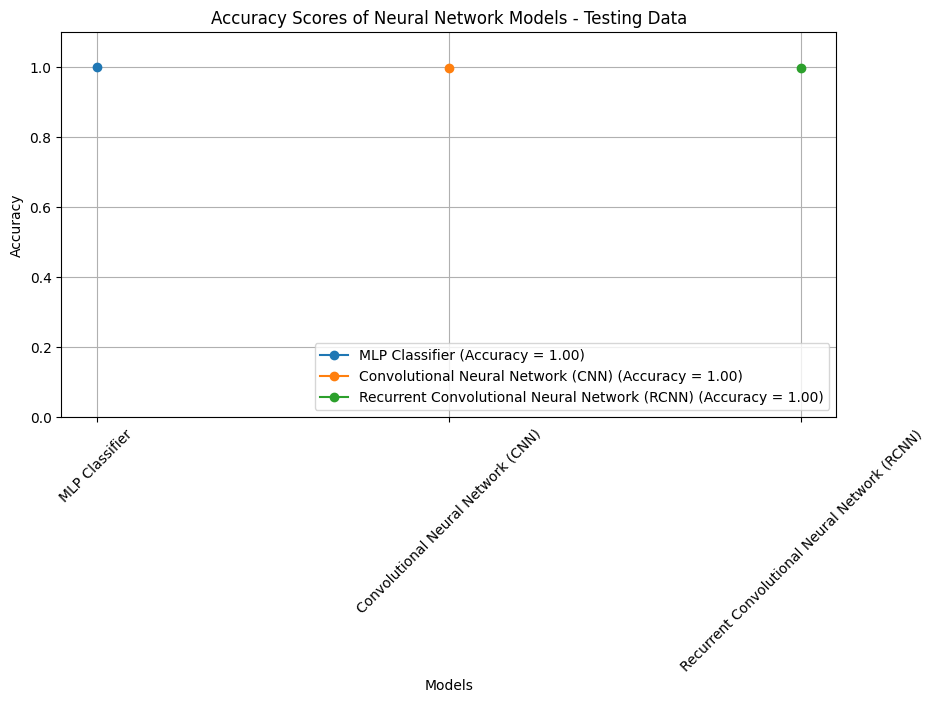

In [11]:
# Neural Network models
mlp = MLPClassifier()

cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(50, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

rcnn = Sequential()
rcnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
rcnn.add(MaxPooling1D(pool_size=2))
rcnn.add(LSTM(100))
rcnn.add(Dense(1, activation='sigmoid'))

# Neural network models
nn_models = {
    'MLP Classifier': mlp,
    'Convolutional Neural Network (CNN)': cnn,
    'Recurrent Convolutional Neural Network (RCNN)': rcnn
}

# Train and evaluate the neural network models 
roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict = train_and_evaluate_models(nn_models, X_train, X_test, y_train, y_test)
    
plot_evaluation_curves(roc_auc_scores, pr_auc_scores, accuracy_scores, fpr_tpr_dict, p_r_dict, 'Neural Network Models')